# A Small Experiment of PU Learning

This is to understanding how PU learning works in Multi-Class Outlier Detection cases


### Setup

In [163]:
# This helps when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multitest import multipletests
import copy

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores, compute_mean_distance, adjust_proportions, prepare_pu_score_matrices
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

In [164]:
# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 4

# Training, Calibration, and Test data
num_in_train = 2000
n_in_cal = [500, 500]
n_in_test = [1710, 90]
n_out_test = 200
n_test = num_n_in_test + n_out_test

# Range of rho values
rho_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Monte Carlo iterations
num_iterations = 10

## Preparation

In [165]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

# Define machine learning models
binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

In [166]:
# Store results
mean_distances = {
    'multi_step': [],
    'multi_step_subsample': [],
    'multi_step_boostrap': []
}

ci_distances = {
    'multi_step': [],
    'multi_step_subsample': [],
    'multi_step_boostrap': []
}

mean_fdr = {
    'multi_step': [],
    'multi_step_subsample': [],
    'multi_step_boostrap': []
}

ci_fdr = {
    'multi_step': [],
    'multi_step_subsample': [],
    'multi_step_boostrap': []   
}

mean_power = {
    'multi_step': [],
    'multi_step_subsample': [],
    'multi_step_boostrap': []
}

ci_power = {
    'multi_step': [],
    'multi_step_subsample': [],
    'multi_step_boostrap': []
}

### Three PU Learning Methods(One-Step, Two_Step, Multi_step)

In [167]:
for rho in rho_values:
    n_in_train = [int(rho * num_in_train), num_in_train- int(rho * num_in_train) ]

    distances_multi_step = []
    distances_subsample = []
    distances_boostrap = []
    fdr_multi_step_vec = []
    fdr_subsample_vec = []
    fdr_boostrap_vec = []
    power_multi_step_vec = []
    power_subsample_vec = []
    power_boostrap_vec = []

    for _ in range(num_iterations):
        # Generate initial training, calibration, and test data
        X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
        X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
        X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)

        # Adjust the proportions in the training data
        X_train_subsample, Y_train_subsample = adjust_proportions(X_train, Y_train, X_cal, X_test, oneclass_classifier, K, method='subsample')
        X_train_boostrap, Y_train_boostrap = adjust_proportions(X_train, Y_train, X_cal, X_test, oneclass_classifier, K, method='bootstrap')

        # Compute PU scores
        scores_cal_multi_step, scores_test_multi_step, _ = compute_pu_scores(
            K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
            oneclass_classifier=oneclass_classifier, multi_step=True)

        scores_cal_subsample, scores_test_subsample, _ = compute_pu_scores(
            K, X_train_subsample, Y_train_subsample, X_cal, Y_cal, X_test, binary_classifier,
            oneclass_classifier=oneclass_classifier, multi_step=True)

        scores_cal_boostrap, scores_test_boostrap, _ = compute_pu_scores(
            K, X_train_boostrap, Y_train_boostrap, X_cal, Y_cal, X_test, binary_classifier,
            oneclass_classifier=oneclass_classifier, multi_step=True)

        # Compute mean distances
        distances_multi_step.append(compute_mean_distance(K, scores_test_multi_step, Y_test))
        distances_subsample.append(compute_mean_distance(K, scores_test_subsample, Y_test))
        distances_boostrap.append(compute_mean_distance(K, scores_test_boostrap, Y_test))

        # transform the format of scores
        scores_cal_mat, scores_test_mat = prepare_pu_score_matrices(K, n_in_cal, n_test, scores_cal_multi_step, scores_test_multi_step)
        scores_cal_mat_subsample, scores_test_mat_subsample = prepare_pu_score_matrices(K, n_in_cal, n_test, scores_cal_subsample, scores_test_subsample)
        scores_cal_mat_boostrap, scores_test_mat_boostrap = prepare_pu_score_matrices(K, n_in_cal, n_test, scores_cal_boostrap, scores_test_boostrap)

        # Compute MAMCOD conformal p-values
        MAMCOD_pv = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat, scores_test_mat, is_high_score_inlier = False)
        MAMCOD_pv_subsample = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_subsample, scores_test_mat_subsample, is_high_score_inlier = False)
        MAMCOD_pv_boostrap = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_boostrap, scores_test_mat_boostrap, is_high_score_inlier = False)

        # Compute FDR and Power by BH procedure
        fdr, power = compute_fdr_power(MAMCOD_pv, Y_test, alpha = 0.1)
        fdr_subsample, power_subsample = compute_fdr_power(MAMCOD_pv_subsample, Y_test, alpha = 0.1)
        fdr_boostrap, power_boostrap = compute_fdr_power(MAMCOD_pv_boostrap, Y_test, alpha = 0.1)
        
        fdr_multi_step_vec.append(fdr)
        fdr_subsample_vec.append(fdr_subsample)
        fdr_boostrap_vec.append(fdr_boostrap)
        power_multi_step_vec.append(power)
        power_subsample_vec.append(power_subsample)
        power_boostrap_vec.append(power_boostrap)    

    # Calculate mean distances and confidence intervals
    mean_distances['multi_step'].append(np.mean(distances_multi_step))
    mean_distances['multi_step_subsample'].append(np.mean(distances_subsample))
    mean_distances['multi_step_boostrap'].append(np.mean(distances_boostrap))
    
    mean_fdr['multi_step'].append(np.mean(fdr_multi_step_vec))
    mean_fdr['multi_step_subsample'].append(np.mean(fdr_subsample_vec))
    mean_fdr['multi_step_boostrap'].append(np.mean(fdr_boostrap_vec))
    
    mean_power['multi_step'].append(np.mean(power_multi_step_vec))
    mean_power['multi_step_subsample'].append(np.mean(power_subsample_vec))
    mean_power['multi_step_boostrap'].append(np.mean(power_boostrap_vec))

    # Compute the standard deviation
    ci_distances['multi_step'].append((np.percentile(distances_multi_step, 5), np.percentile(distances_multi_step, 95)))
    ci_distances['multi_step_subsample'].append((np.percentile(distances_subsample, 5), np.percentile(distances_subsample, 95)))
    ci_distances['multi_step_boostrap'].append((np.percentile(distances_boostrap, 5), np.percentile(distances_boostrap, 95)))
    
    ci_fdr['multi_step'].append((np.percentile(fdr_multi_step_vec, 5), np.percentile(fdr_multi_step_vec, 95)))
    ci_fdr['multi_step_subsample'].append((np.percentile(fdr_subsample_vec, 5), np.percentile(fdr_subsample_vec, 95)))
    ci_fdr['multi_step_boostrap'].append((np.percentile(fdr_boostrap_vec, 5), np.percentile(fdr_boostrap_vec, 95)))
    
    ci_power['multi_step'].append((np.percentile(power_multi_step_vec, 5), np.percentile(power_multi_step_vec, 95)))
    ci_power['multi_step_subsample'].append((np.percentile(power_subsample_vec, 5), np.percentile(power_subsample_vec, 95)))
    ci_power['multi_step_boostrap'].append((np.percentile(power_boostrap_vec, 5), np.percentile(power_boostrap_vec, 95)))

### Plot

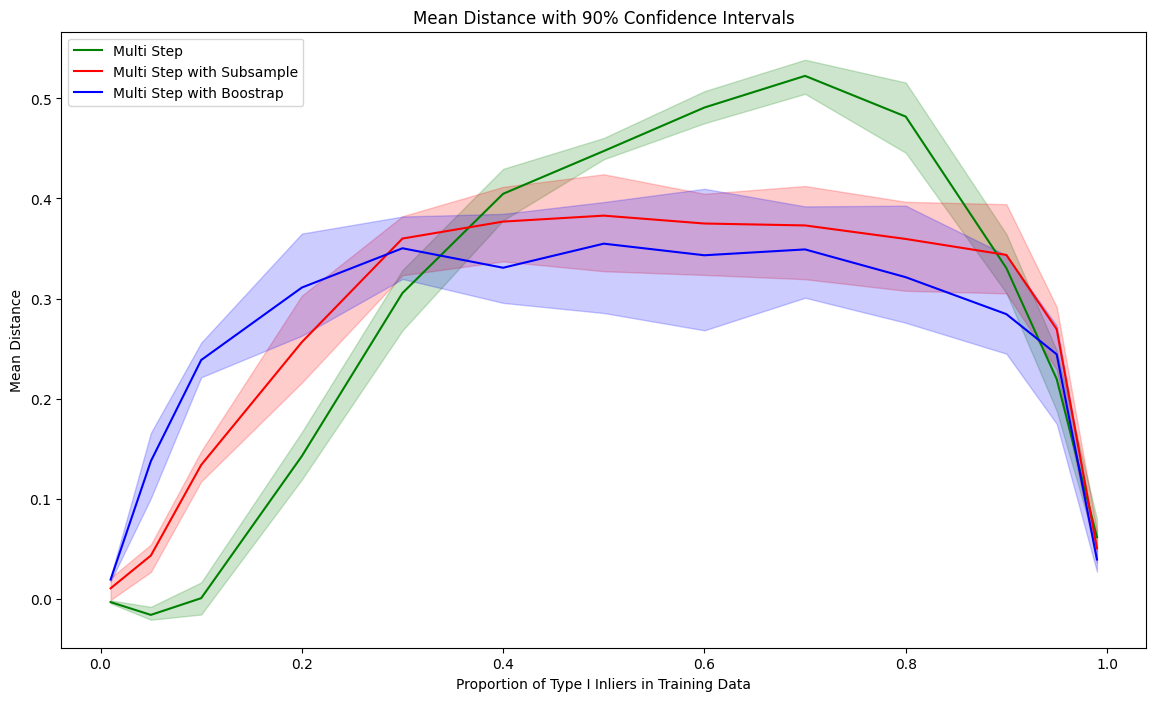

In [168]:
# Plotting
plt.figure(figsize=(14, 8))

plt.plot(rho_values, mean_distances['multi_step'], label='Multi Step', color='g')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['multi_step']], [ci[1] for ci in ci_distances['multi_step']], color='g', alpha=0.2)

plt.plot(rho_values, mean_distances['multi_step_subsample'], label='Multi Step with Subsample', color='r')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['multi_step_subsample']], [ci[1] for ci in ci_distances['multi_step_subsample']], color='r', alpha=0.2)

plt.plot(rho_values, mean_distances['multi_step_boostrap'], label='Multi Step with Boostrap', color='b')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['multi_step_boostrap']], [ci[1] for ci in ci_distances['multi_step_boostrap']], color='b', alpha=0.2)

plt.xlabel('Proportion of Type I Inliers in Training Data')
plt.ylabel('Mean Distance')
plt.title('Mean Distance with 90% Confidence Intervals')
plt.legend()
plt.show()

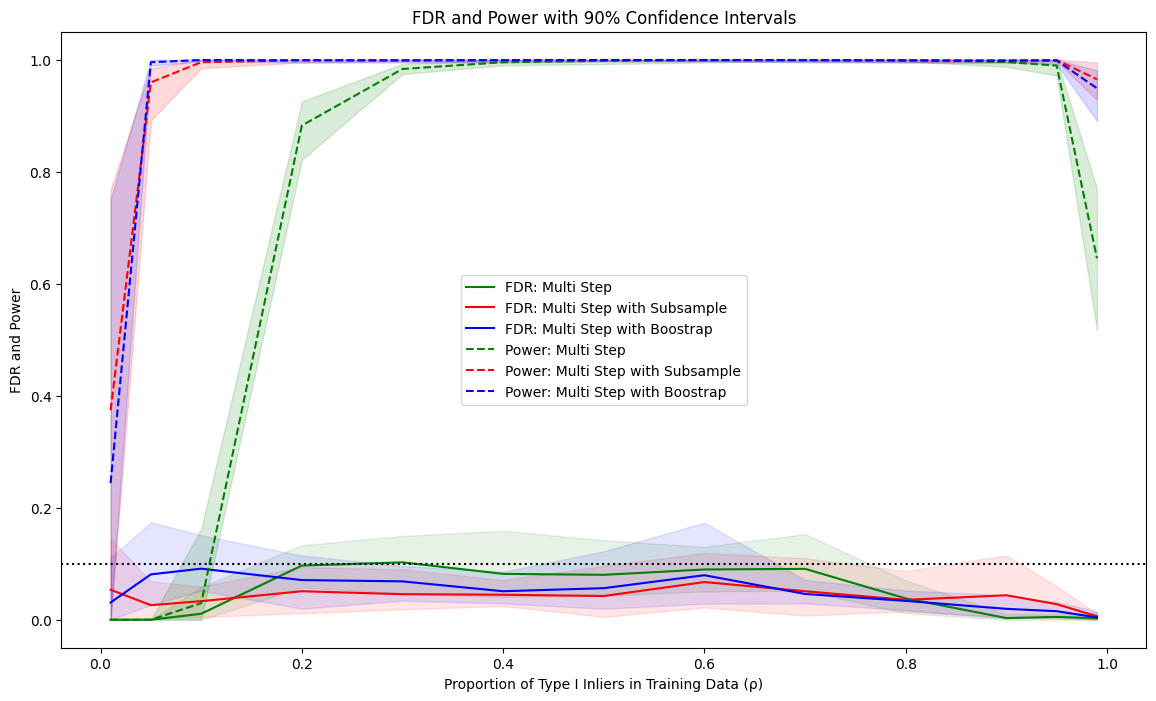

In [169]:
# Plotting
plt.figure(figsize=(14, 8))

## Plot FDR
plt.plot(rho_values, mean_fdr['multi_step'], label='FDR: Multi Step', color='g', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['multi_step']], [ci[1] for ci in ci_fdr['multi_step']], color='g', alpha=0.1)

plt.plot(rho_values, mean_fdr['multi_step_subsample'], label='FDR: Multi Step with Subsample', color='r', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['multi_step_subsample']], [ci[1] for ci in ci_fdr['multi_step_subsample']], color='r', alpha=0.1)

plt.plot(rho_values, mean_fdr['multi_step_boostrap'], label='FDR: Multi Step with Boostrap', color='b', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['multi_step_boostrap']], [ci[1] for ci in ci_fdr['multi_step_boostrap']], color='b', alpha=0.1)

## Plot Power
plt.plot(rho_values, mean_power['multi_step'], label='Power: Multi Step', color='g', linestyle='--')
plt.fill_between(rho_values, [ci[0] for ci in ci_power['multi_step']], [ci[1] for ci in ci_power['multi_step']], color='g', alpha=0.15)

plt.plot(rho_values, mean_power['multi_step_subsample'], label='Power: Multi Step with Subsample', color='r', linestyle='--')
plt.fill_between(rho_values, [ci[0] for ci in ci_power['multi_step_subsample']], [ci[1] for ci in ci_power['multi_step_subsample']], color='r', alpha=0.15)

plt.plot(rho_values, mean_power['multi_step_boostrap'], label='Power: Multi Step with Boostrap', color='b', linestyle='--')
plt.fill_between(rho_values, [ci[0] for ci in ci_power['multi_step_boostrap']], [ci[1] for ci in ci_power['multi_step_boostrap']], color='b', alpha=0.15)

# Add horizontal line at y = 0.1
plt.axhline(y=0.1, color='k', linestyle=':')

plt.xlabel('Proportion of Type I Inliers in Training Data (ρ)')
plt.ylabel('FDR and Power')
plt.title('FDR and Power with 90% Confidence Intervals')
plt.legend()
plt.show()

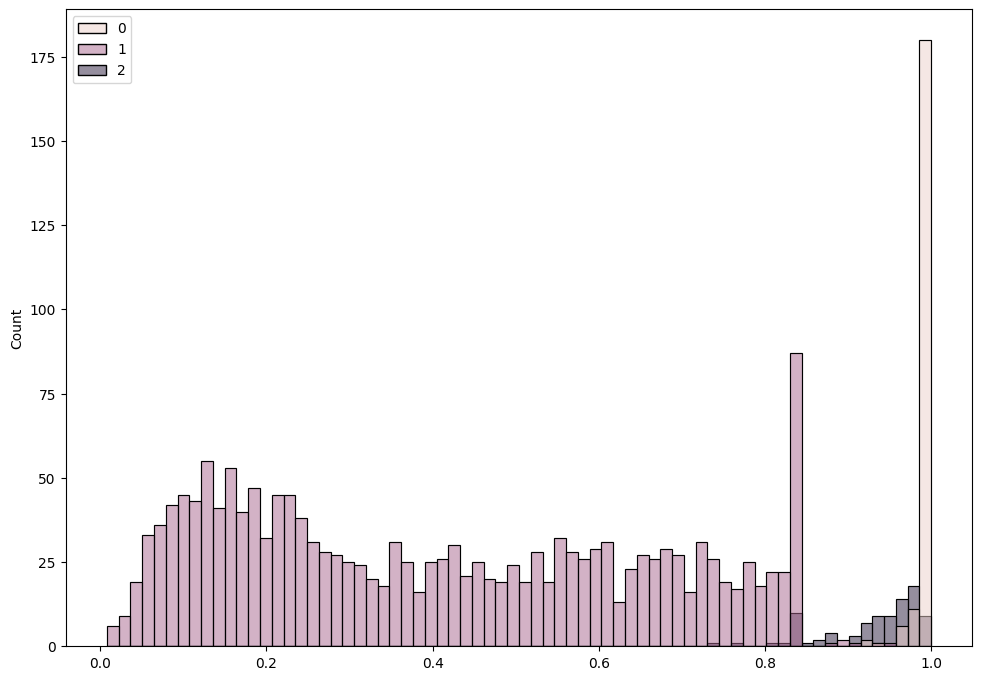

In [170]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27
sns.histplot(x=scores_test_multi_step, hue=Y_test, bins=70)
plt.show()

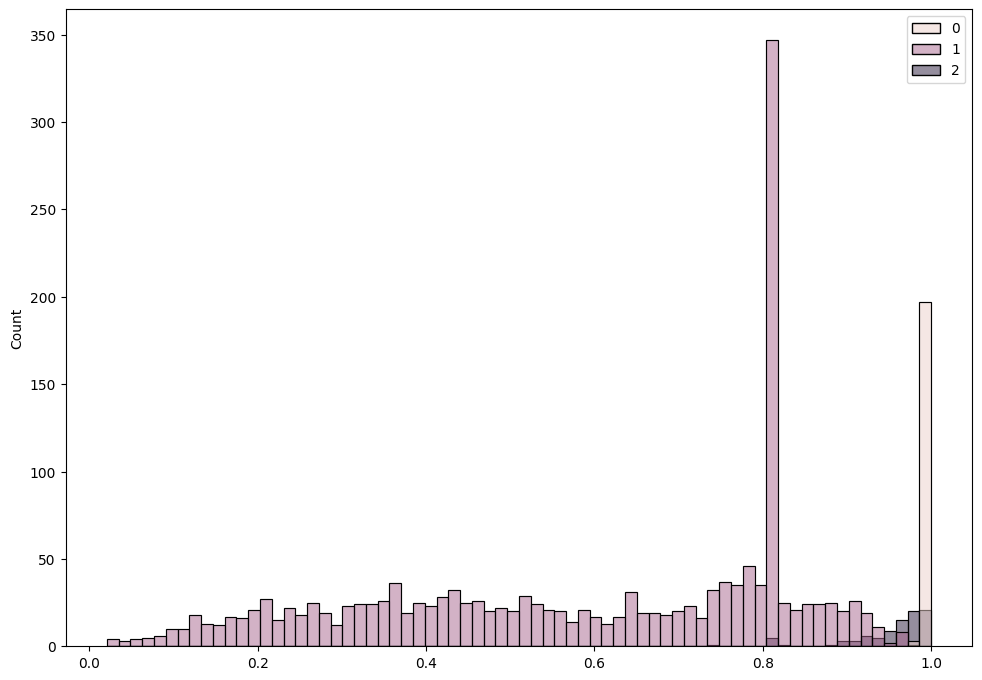

In [171]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27
sns.histplot(x=scores_test_subsample, hue=Y_test, bins=70)
plt.show()

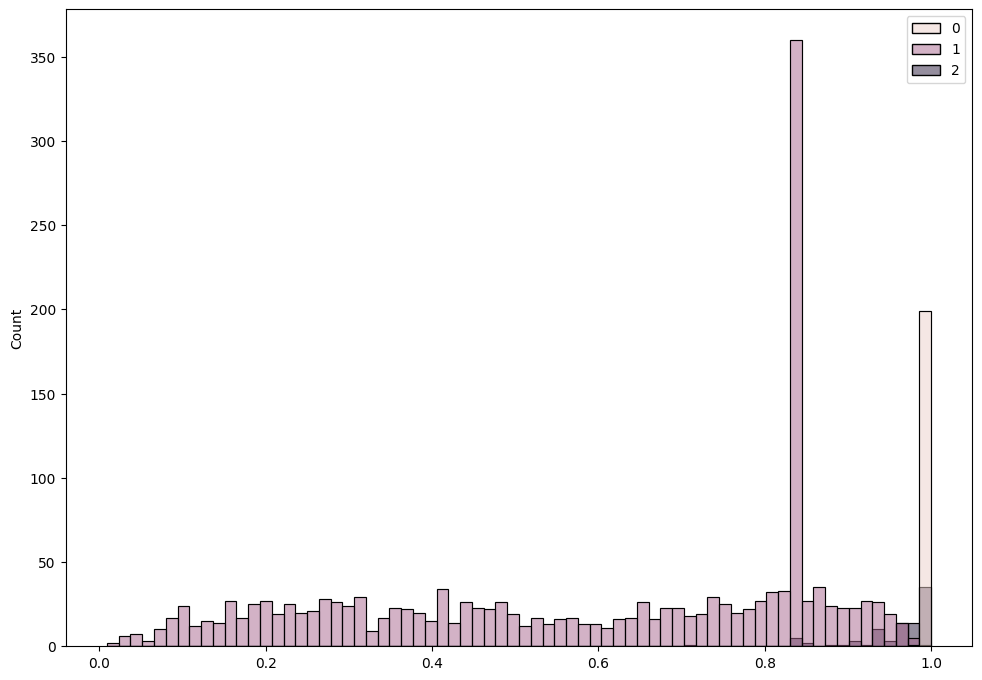

In [172]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27
sns.histplot(x=scores_test_boostrap, hue=Y_test, bins=70)
plt.show()